<a href="https://colab.research.google.com/github/DreamingNight/BookxNoteData/blob/master/chapter03/Chapter%203%20-%20Looking%20Inside%20LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Chapter 3 - Looking Inside Transformer LLMs</h1>
<i>An extensive look into the transformer architecture of generative LLMs</i>

<a href="https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961"><img src="https://img.shields.io/badge/Buy%20the%20Book!-grey?logo=amazon"></a>
<a href="https://www.oreilly.com/library/view/hands-on-large-language/9781098150952/"><img src="https://img.shields.io/badge/O'Reilly-white.svg?logo=data:image/svg%2bxml;base64,PHN2ZyB3aWR0aD0iMzQiIGhlaWdodD0iMjciIHZpZXdCb3g9IjAgMCAzNCAyNyIgZmlsbD0ibm9uZSIgeG1sbnM9Imh0dHA6Ly93d3cudzMub3JnLzIwMDAvc3ZnIj4KPGNpcmNsZSBjeD0iMTMiIGN5PSIxNCIgcj0iMTEiIHN0cm9rZT0iI0Q0MDEwMSIgc3Ryb2tlLXdpZHRoPSI0Ii8+CjxjaXJjbGUgY3g9IjMwLjUiIGN5PSIzLjUiIHI9IjMuNSIgZmlsbD0iI0Q0MDEwMSIvPgo8L3N2Zz4K"></a>
<a href="https://github.com/HandsOnLLM/Hands-On-Large-Language-Models"><img src="https://img.shields.io/badge/GitHub%20Repository-black?logo=github"></a>


This notebook is for Chapter 3 of the [Hands-On Large Language Models](https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961) book by [Jay Alammar](https://www.linkedin.com/in/jalammar) and [Maarten Grootendorst](https://www.linkedin.com/in/mgrootendorst/).

---

<a href="https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961">
<img src="https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/images/book_cover.png" width="350"/></a>

### [OPTIONAL] - Installing Packages on <img src="https://colab.google/static/images/icons/colab.png" width=100>

If you are viewing this notebook on Google Colab (or any other cloud vendor), you need to **uncomment and run** the following codeblock to install the dependencies for this chapter:

---

💡 **NOTE**: We will want to use a GPU to run the examples in this notebook. In Google Colab, go to
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---


In [ ]:
%%capture
!pip install transformers==4.46.2 accelerate>=0.31.0

In [ ]:
!pip list | grep transformers

sentence-transformers              3.4.1
transformers                       4.46.2


## 这本书主要是提供关于LLM的一些直觉intuition


# Loading the LLM

In [ ]:
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [ ]:
import gc
gc.collect()

0

In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)

# Create a pipeline
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=False,
    max_new_tokens=200,
    do_sample=False,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# The Inputs and Outputs of a Trained Transformer LLM


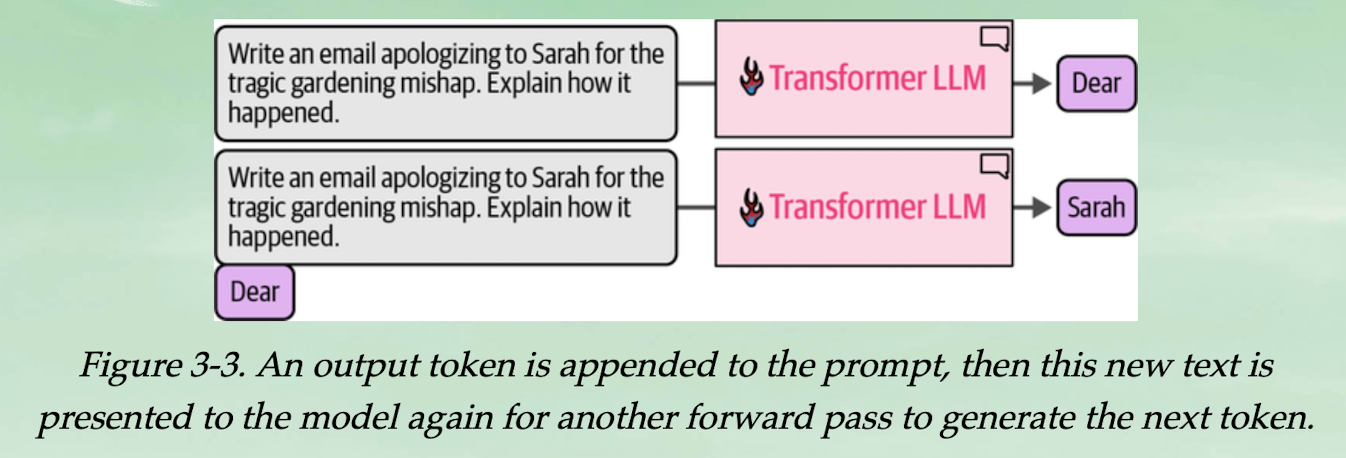

LLM 每次运行只能生成一个token，而不是直接输出所有的文本。并且在输入一个token后，他会和前面的内容组合起来作为input用于产生下一个token。用机器学习中的术语来描述，它是一个autoregressive models，自回归模型。
因为它会使用模型生成的token来生成下一个token。

所以文本生成模型经常被称为自回归模型。而BERT这种文本标识模型就不是自回归的。


---


但是，看到这我有一个疑问：LLM如何决定停止输出呢？总不能每次都到达context的上限，难道是它认为生成完毕的时候会输出作为结尾的那个特殊token吗？

In [ ]:
prompt = "Write an email apologizing to Sarah for the tragic gardening mishap. Explain how it happened."

output = generator(prompt)

print(output[0]['generated_text'])

 Mention the steps you're taking to prevent it in the future.

Dear Sarah,

I hope this message finds you well. I am writing to express my deepest apologies for the unfortunate incident that occurred in your garden. It was a tragic mishap that I never intended, and I am truly sorry for any distress it may have caused you.

The incident happened when I was attempting to help you with your gardening project. I had been researching various techniques to improve the health and growth of your plants, and I thought I had found the perfect solution. However, in my eagerness to implement this new method, I accidentally damaged some of your delicate flowers and disrupted the balance of your carefully cultivated ecosystem.

I understand that my actions have caused significant harm to your garden, and I am sincerely sorry for the consequences. Please know that I take full responsibility for my


In [ ]:
print(model)

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3RotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm()
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm()
      )
    )
    (norm): Phi3RMSNorm()
  )
  (lm_head): Linear(in_features=3072, out_features=3206

# Choosing a single token from the probability distribution (sampling / decoding)

In [ ]:
prompt = "The capital of France is"

# Tokenize the input prompt
input_ids = tokenizer(prompt, return_tensors="pt").input_ids

# Tokenize the input prompt
input_ids = input_ids.to("cuda")

# Get the output of the model before the lm_head
model_output = model.model(input_ids)

# Get the output of the lm_head
lm_head_output = model.lm_head(model_output[0])

In [ ]:
token_id = lm_head_output[0,-1].argmax(-1)
tokenizer.decode(token_id)

'Paris'

In [ ]:
model_output[0].shape

torch.Size([1, 6, 3072])

In [ ]:
lm_head_output.shape

torch.Size([1, 6, 32064])

# Speeding up generation by caching keys and values


In [ ]:
prompt = "Write a very long email apologizing to Sarah for the tragic gardening mishap. Explain how it happened."

# Tokenize the input prompt
input_ids = tokenizer(prompt, return_tensors="pt").input_ids
input_ids = input_ids.to("cuda")

In [ ]:
%%timeit -n 1
# Generate the text
generation_output = model.generate(
  input_ids=input_ids,
  max_new_tokens=100,
  use_cache=True
)

6.66 s ± 2.22 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit -n 1
# Generate the text
generation_output = model.generate(
  input_ids=input_ids,
  max_new_tokens=100,
  use_cache=False
)

21.9 s ± 94.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
